In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_style('whitegrid')

In [39]:
metrics = pd.read_csv('../logs/lightning_logs/version_18/metrics.csv')
metrics.head(2)

,step,train_loss,epoch,val_loss_step,val_loss_epoch,val_accuracy,train_accuracy
0,99,3.85961,0.0,NaN,NaN,NaN,NaN
1,0,NaN,NaN,3.775011,NaN,NaN,NaN


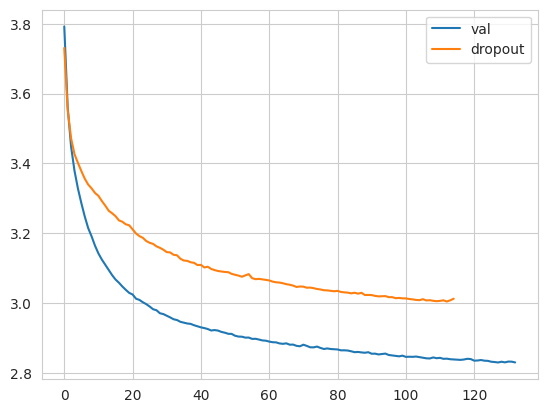

In [40]:
metrics = pd.read_csv('../logs/lightning_logs/version_18/metrics.csv')
val_loss = metrics[['step', 'val_loss_epoch']].dropna()
val_loss['g'] = val_loss['step'] // 100
val_loss = val_loss.groupby('g')['val_loss_epoch'].mean()
plt.plot(val_loss.index, val_loss, label='val')

metrics = pd.read_csv('../logs/lightning_logs/version_24/metrics.csv')
val_loss = metrics[['step', 'val_loss_epoch']].dropna()
val_loss['g'] = val_loss['step'] // 100
val_loss = val_loss.groupby('g')['val_loss_epoch'].mean()
plt.plot(val_loss.index, val_loss, label='dropout')

plt.legend()
plt.show()

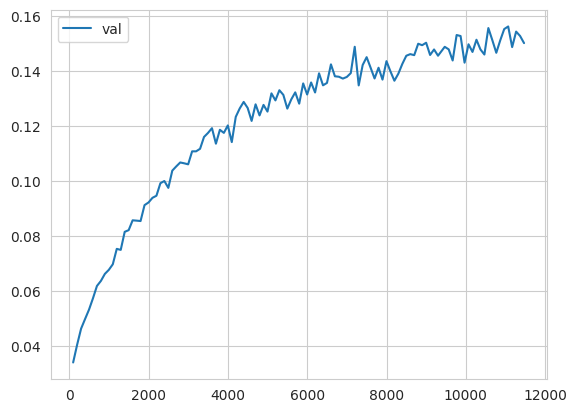

In [41]:
val_accuracy = metrics[['epoch', 'step', 'val_accuracy']].dropna()
plt.plot(val_accuracy['step'], val_accuracy['val_accuracy'], label='val')

plt.legend()
plt.show()

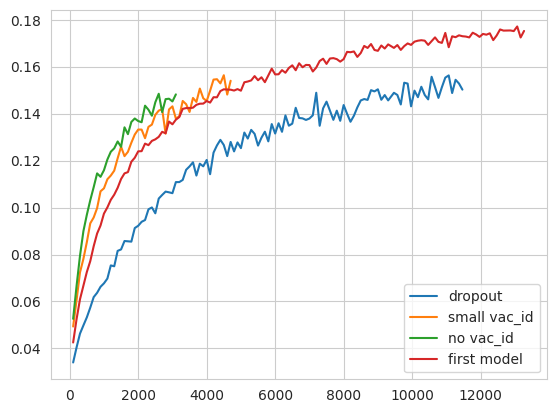

In [42]:
metrics = pd.read_csv('../logs/lightning_logs/version_24/metrics.csv')
val_accuracy = metrics[['epoch', 'step', 'val_accuracy']].dropna()
plt.plot(val_accuracy['step'], val_accuracy['val_accuracy'], label='dropout')

metrics = pd.read_csv('../logs/lightning_logs/version_23/metrics.csv')
val_accuracy = metrics[['epoch', 'step', 'val_accuracy']].dropna()
plt.plot(val_accuracy['step'], val_accuracy['val_accuracy'], label='small vac_id')

metrics = pd.read_csv('../logs/lightning_logs/version_22/metrics.csv')
val_accuracy = metrics[['epoch', 'step', 'val_accuracy']].dropna()
plt.plot(val_accuracy['step'], val_accuracy['val_accuracy'], label='no vac_id')


metrics = pd.read_csv('../logs/lightning_logs/version_18/metrics.csv')
val_accuracy = metrics[['epoch', 'step', 'val_accuracy']].dropna()
plt.plot(val_accuracy['step'], val_accuracy['val_accuracy'], label='first model')

plt.legend()
plt.show()

## Загрузка модели

In [1]:
!ls ../data | grep ckpt

epoch=1-step=11169.ckpt
epoch=1-step=13269.ckpt


In [2]:
from hh.dssm import (
    DSSM,
    EmbedMultipleVac,
    EmbedSingleVac,
    VacancyDescription,
)
import torch
from sklearn import manifold

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import polars as pl

import hnswlib

sns.set_style('whitegrid')

In [3]:
description = VacancyDescription(path='../data/vacancy_features.pq')
dssm = DSSM(
    embed_x=EmbedMultipleVac(description=description),
    embed_y=EmbedSingleVac(description=description),
)
dssm = DSSM.load_from_checkpoint(
    '../data/epoch=1-step=13269.ckpt',
    embed_x=EmbedMultipleVac(description=description),
    embed_y=EmbedSingleVac(description=description),
)

In [116]:
dssm

DSSM(
  (embed_x): EmbedMultipleVac(
    (vacancy_id_embed): EmbeddingBag(2734130, 32, mode='mean')
    (company_id): EmbeddingBag(278913, 16, mode='mean')
    (area_id): EmbeddingBag(7015, 16, mode='mean')
    (area_region_id): EmbeddingBag(107, 8, mode='mean')
    (employment): EmbeddingBag(6, 4, mode='mean')
    (work_schedule): EmbeddingBag(6, 4, mode='mean')
    (work_experience): EmbeddingBag(5, 4, mode='mean')
    (compensation_currency_code): EmbeddingBag(11, 4, mode='mean')
    (name): EmbeddingBag(18060, 16, mode='mean')
    (fc): Linear(in_features=104, out_features=64, bias=True)
  )
  (embed_y): EmbedSingleVac(
    (vacancy_id_embed): Embedding(2734130, 32)
    (company_id): Embedding(278913, 16)
    (area_id): Embedding(7015, 16)
    (area_region_id): Embedding(107, 8)
    (employment): Embedding(6, 4)
    (work_schedule): Embedding(6, 4)
    (work_experience): Embedding(5, 4)
    (compensation_currency_code): Embedding(11, 4)
    (name): Embedding(18060, 16)
    (fc): Li

In [147]:
vacs = torch.arange(0, description.company_id.shape[0], dtype=torch.long)

In [148]:
description.name = description.name.clip(max=18059)

In [149]:
vac_embeddings = dssm.embed_y(vacs)

In [150]:
x = vac_embeddings.detach().cpu().numpy()
x.shape

(2734130, 64)

In [151]:
y = manifold.TSNE().fit_transform(x[:1000])
y.shape

(1000, 2)

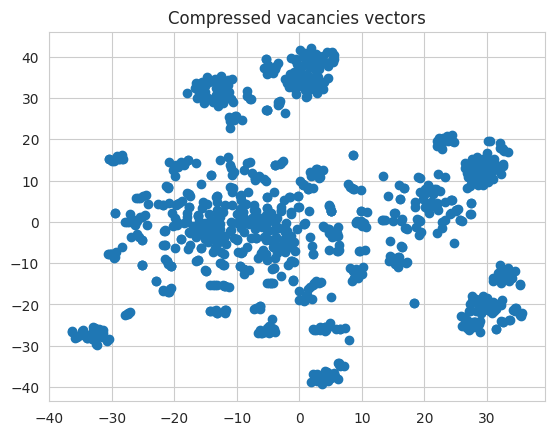

In [152]:
plt.scatter(y[:, 0], y[:, 1])
plt.title('Compressed vacancies vectors')
plt.show()

In [153]:
# users_df = pl.read_parquet('../data/user_application_features.pq')
users_df = pl.read_parquet('../data/dssm_train.pq')
users_df.head(2)

user_id,n_sessions,vacancy_id,action_type,is_test,session_id,session_end,target
str,u32,list[u64],list[i64],bool,str,datetime[ns],u64
"""u_237129""",2,"[1481580, 208271, … 1606798]","[2, 2, … 2]",false,"""s_361359""",2023-11-13 12:08:36.976,716724
"""u_237129""",2,"[1481580, 208271, … 1606798]","[2, 2, … 2]",false,"""s_361359""",2023-11-13 12:08:36.976,690666


In [154]:
HISTORY_LENGTH = 16

def _pad(seqs):
    def pad_seq(seq):
        seq = seq[:HISTORY_LENGTH]
        return seq + [0] * (HISTORY_LENGTH - len(seq))
    return [pad_seq(seq) for seq in seqs]
users_tensor = torch.tensor(_pad(users_df['vacancy_id'].to_list()), dtype=torch.long)
users_tensor.shape

torch.Size([348698, 16])

In [155]:
target_tensor = torch.tensor(users_df['target'].to_list())
target_tensor.shape

torch.Size([348698])

In [156]:
batch_size = 32
batch = users_tensor[:batch_size], target_tensor[:batch_size]
logits = dssm(*batch)

In [157]:
(logits.argmax(axis=0) == torch.arange(0, batch_size)).float().mean()

tensor(0.2188)

In [158]:
user_embeddings = dssm.embed_x(users_tensor).detach().cpu().numpy()

In [159]:
logits[0, 0]

tensor(7.0255, grad_fn=<SelectBackward0>)

In [162]:
(user_embeddings[0] * x[targets[0]]).sum()

7.025489

In [163]:
(user_embeddings * x[targets - 1]).mean()

0.0027159466

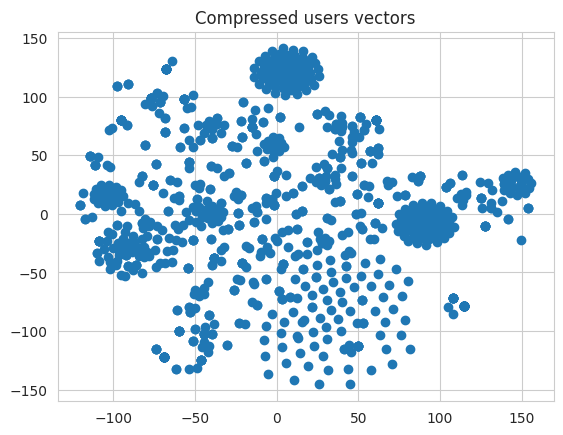

In [164]:
uy = manifold.TSNE().fit_transform(user_embeddings[:1000])
plt.scatter(uy[:, 0], uy[:, 1])
plt.title('Compressed users vectors')
plt.show()

In [174]:
def cos(a, b):
    return (1 - (a * b).sum() / np.linalg.norm(a) / np.linalg.norm(b)) / 2


In [165]:
%%time

num_elements, dim = x.shape

ids = np.arange(num_elements)

# Declaring index
p = hnswlib.Index(space = 'ip', dim = dim) # possible options are l2, cosine or ip

# Initializing index - the maximum number of elements should be known beforehand
p.init_index(max_elements=num_elements, ef_construction=400, M=16)

# Element insertion (can be called several times):
p.add_items(x, ids)


CPU times: user 40min 44s, sys: 10.8 s, total: 40min 55s
Wall time: 3min 59s


In [166]:
%%time

# Controlling the recall by setting ef:
p.set_ef(200) # ef should always be > k

# Query dataset, k - number of the closest elements (returns 2 numpy arrays)
labels, distances = p.knn_query(user_embeddings, k = 100)

CPU times: user 1min 57s, sys: 1.37 s, total: 1min 58s
Wall time: 11.1 s


In [22]:
targets = np.array(users_df['target'].to_list())

In [172]:
is_test = np.array(users_df['is_test'].to_list())

In [173]:
(labels[is_test] == targets[is_test, None]).sum()

429

In [175]:
ts, cs = np.unique(targets, return_counts=True)

In [182]:
cs.sum(), cs[cs > 10].sum()

(348698, 57901)

In [177]:
goodts = ts[cs > 10]
goodts.shape

(2956,)

In [178]:
%%time

num_elements, dim = goodts.shape[0], x.shape[1]

ids = goodts

# Declaring index
p = hnswlib.Index(space='ip', dim=dim) # possible options are l2, cosine or ip

# Initializing index - the maximum number of elements should be known beforehand
p.init_index(max_elements=num_elements, ef_construction=400, M=16)

# Element insertion (can be called several times):
p.add_items(x[goodts], ids)


CPU times: user 1.04 s, sys: 180 ms, total: 1.22 s
Wall time: 535 ms


In [179]:
%%time

# Controlling the recall by setting ef:
p.set_ef(200) # ef should always be > k

# Query dataset, k - number of the closest elements (returns 2 numpy arrays)
labels, distances = p.knn_query(user_embeddings, k = 100)

CPU times: user 40.7 s, sys: 657 ms, total: 41.3 s
Wall time: 3.89 s


In [181]:
(labels == targets[:, None]).sum()

12816

In [214]:
for th in [10, 5, 4, 3, 2, 1, 0]:
    goodts = ts[cs >= th]
    p = hnswlib.Index(space='ip', dim=dim)
    p.init_index(max_elements=goodts.shape[0], ef_construction=400, M=16)
    p.add_items(x[goodts], goodts)
    labels, distances = p.knn_query(user_embeddings, k = 200)
    n_matches = (labels[is_test] == targets[is_test, None]).sum()
    print(f'Threshold: {th}, n_matches: {n_matches}')


Threshold: 10, n_matches: 2635
Threshold: 5, n_matches: 2912
Threshold: 4, n_matches: 3046
Threshold: 3, n_matches: 3218
Threshold: 2, n_matches: 3512
Threshold: 1, n_matches: 3310
Threshold: 0, n_matches: 3309


In [213]:
for th in [10, 5, 4, 3, 2, 1, 0]:
    goodts = ts[cs >= th]
    p = hnswlib.Index(space='ip', dim=dim)
    p.init_index(max_elements=goodts.shape[0], ef_construction=400, M=16)
    p.add_items(x[goodts], goodts)
    labels, distances = p.knn_query(user_embeddings, k = 100)
    n_matches = (labels[is_test] == targets[is_test, None]).sum()
    print(f'Threshold: {th}, n_matches: {n_matches}')


Threshold: 10, n_matches: 1770
Threshold: 5, n_matches: 1979
Threshold: 4, n_matches: 2068
Threshold: 3, n_matches: 2206
Threshold: 2, n_matches: 2335
Threshold: 1, n_matches: 2019
Threshold: 0, n_matches: 2015


In [210]:
users_df.filter(pl.col('is_test')).group_by('user_id').count().count()

user_id,count
u32,u32
15526,15526


In [205]:
((labels == targets[:, None]) / np.arange(1, 101)).sum(axis=1)[is_test].mean()

0.0034207116439865315

In [228]:
pl.DataFrame().with_columns(
    users_df['user_id'],
    dssm=labels,
    dssm_distances=distances,
).select(
    pl.col('dssm'),
    pl.col('dssm_distances'),
    pl.col('user_id').cast(pl.String),
)

dssm,dssm_distances,user_id
list[u64],list[f32],str
"[1009738, 40873, … 1403852]","[-7.823747, -7.814659, … -6.208184]","""u_237129"""
"[1009738, 40873, … 1403852]","[-7.823747, -7.814659, … -6.208184]","""u_237129"""
"[2702506, 407412, … 2457430]","[-3.097103, -2.984145, … -2.236562]","""u_864547"""
"[2702506, 407412, … 2457430]","[-3.097103, -2.984145, … -2.236562]","""u_864547"""
"[172073, 56614, … 636499]","[-3.209113, -3.062974, … -2.61508]","""u_67865"""
"[172073, 56614, … 636499]","[-3.209113, -3.062974, … -2.61508]","""u_67865"""
"[1005608, 542654, … 983755]","[-2.740745, -2.649535, … -2.230035]","""u_408815"""
"[1005608, 542654, … 983755]","[-2.740745, -2.649535, … -2.230035]","""u_408815"""
"[1005608, 542654, … 983755]","[-2.740745, -2.649535, … -2.230035]","""u_408815"""


In [62]:
import polars as pl

from hh import utils

In [3]:
!ls ../data

 d_history_plus_dssm.pq     history_plus_dssm.pq
 dssm_prediction.pq	    test.fth
 dssm_test_prediction.pq    train.fth
 dssm_train.pq		    train.sample.fth
'epoch=1-step=11169.ckpt'   train.small_sample.fth
'epoch=1-step=13269.ckpt'   train_dataset.fth
 hh_recsys_sample.pq	    train_dataset.sample.fth
 hh_recsys_test_hh.pq	    user_application_features.pq
 hh_recsys_train_hh.pq	    vac.no_desc.fth
 hh_recsys_vacancies.pq     vacancy_features.pq
 history_baseline.pq


In [7]:
b = pl.read_parquet('../data/history_baseline.pq')
b.head(3)

user_id,predictions
str,list[str]
"""u_828064""","[""v_21361"", ""v_1642325"", … ""v_1770705""]"
"""u_850674""","[""v_1602597"", ""v_1802097"", … ""v_420479""]"
"""u_67292""","[""v_257694"", ""v_1369548"", ""v_1768728""]"


In [81]:
d = pl.read_parquet('../data/history_plus_dssm.pq')
d.head(3)

user_id,predictions
str,list[str]
"""u_172881""","[""v_156606"", ""v_77234"", … ""v_1664723""]"
"""u_450290""","[""v_982833"", ""v_1101770"", … ""v_890877""]"
"""u_181821""","[""v_2372948"", ""v_627858"", … ""v_237331""]"


In [10]:
b.filter(
    pl.col('user_id') == 'u_862191'
)

user_id,predictions
str,list[str]
"""u_862191""","[""v_2659331"", ""v_2618190"", … ""v_1350016""]"


In [13]:
log = pl.concat([
    pl.read_parquet('../data/hh_recsys_train_hh.pq'),
    pl.read_parquet('../data/hh_recsys_test_hh.pq'),
]).explode(
    'action_dt',
    'vacancy_id',
    'action_type',
).sort(
    'action_dt',
    descending=True,
)
log.head(3)

user_id,session_id,vacancy_id,action_type,action_dt
str,str,str,i64,datetime[ns]
"""u_604698""","""s_424064""","""v_889464""",2,2023-11-21 23:59:59.463
"""u_488695""","""s_30452932""","""v_1344539""",2,2023-11-21 23:59:58.726
"""u_359598""","""s_33602434""","""v_66722""",2,2023-11-21 23:59:57.766


In [69]:
likes = log.filter(
    pl.col('action_type') == 3,
).group_by(
    'user_id',
).agg(
    pl.col('vacancy_id').alias('likes'),
)
likes.head(3)

user_id,likes
str,list[str]
"""u_66687""","[""v_1162244"", ""v_120842"", … ""v_1188493""]"
"""u_657355""","[""v_216258"", ""v_2279628"", … ""v_812771""]"
"""u_683452""","[""v_580530""]"


In [70]:
views = log.filter(
    pl.col('action_type') == 2,
).group_by(
    'user_id',
).agg(
    pl.col('vacancy_id').alias('views'),
)
views.head(3)

user_id,views
str,list[str]
"""u_653282""","[""v_447369"", ""v_2529975"", … ""v_1882081""]"
"""u_389350""","[""v_1170768"", ""v_2125779"", … ""v_368551""]"
"""u_611165""","[""v_733052"", ""v_436310"", … ""v_1318921""]"


In [71]:
applies = log.filter(
    pl.col('action_type') == 1,
).group_by(
    'user_id',
).agg(
    pl.col('vacancy_id').alias('applies'),
)
applies.head(3)

user_id,applies
str,list[str]
"""u_735061""","[""v_1550357"", ""v_120393"", … ""v_290425""]"
"""u_809799""","[""v_683089"", ""v_454980"", … ""v_1682299""]"
"""u_169713""","[""v_2304039"", ""v_2253216""]"


In [72]:
%%time
dssm = pl.read_parquet('../data/dssm_prediction.pq').select(
    pl.col('user_id'),
    pl.col('dssm'),
)
print(dssm['dssm'].list.len().unique())
dssm.head()

shape: (1,)
Series: 'dssm' [u32]
[
	200
]
CPU times: user 20.5 s, sys: 8.87 s, total: 29.4 s
Wall time: 20.2 s


user_id,dssm
str,list[str]
"""u_20816""","[""v_1694818"", ""v_2498568"", … ""v_247290""]"
"""u_417210""","[""v_1108265"", ""v_814288"", … ""v_2691686""]"
"""u_713655""","[""v_1694818"", ""v_2498568"", … ""v_1112428""]"
"""u_199982""","[""v_2498568"", ""v_1694818"", … ""v_2217175""]"
"""u_483444""","[""v_1853938"", ""v_1745542"", … ""v_904167""]"


In [73]:
needed = pl.read_parquet('../data/hh_recsys_test_hh.pq').select(
    pl.col('user_id')
).unique()
print(len(needed))
needed.head()

83189


user_id
str
"""u_384954"""
"""u_112410"""
"""u_168258"""
"""u_37049"""
"""u_404817"""


In [74]:
%%time
res = needed.join(
    likes,
    on='user_id',
    how='left',
).join(
    applies,
    on='user_id',
    how='left',
).join(
    views,
    on='user_id',
    how='left',
).join(
    dssm,
    on='user_id',
    how='left',
).select(
    pl.col('user_id'),
    pl.col('likes').fill_null([]),
    pl.col('applies').fill_null([]),
    pl.col('views').fill_null([]),
    pl.col('dssm').fill_null([]),
)

res.head(3)

CPU times: user 868 ms, sys: 476 ms, total: 1.34 s
Wall time: 808 ms


user_id,likes,applies,views,dssm
str,list[str],list[str],list[str],list[str]
"""u_384954""",[],"[""v_1564592"", ""v_23199"", … ""v_2557303""]","[""v_1564592"", ""v_432069"", … ""v_1734824""]","[""v_2235500"", ""v_2303737"", … ""v_1113235""]"
"""u_112410""",[],"[""v_2730052"", ""v_608354""]","[""v_593272"", ""v_2730052"", … ""v_86011""]","[""v_761006"", ""v_115110"", … ""v_43083""]"
"""u_168258""",[],"[""v_697541""]","[""v_1438469"", ""v_2175269"", … ""v_1438469""]","[""v_219610"", ""v_2685643"", … ""v_2360592""]"


In [75]:
p = res.select(
    pl.col('user_id'),
    pl.concat_list([
        pl.col('likes').list.set_difference('applies'),
        pl.col('views').list.set_difference('applies'),
        pl.col('dssm').list.set_difference('applies'),
    ]).list.unique(maintain_order=True).list.head(100).alias('predictions'),
)
p.head()

user_id,predictions
str,list[str]
"""u_384954""","[""v_1273010"", ""v_432069"", … ""v_231532""]"
"""u_112410""","[""v_593272"", ""v_86011"", … ""v_160657""]"
"""u_168258""","[""v_1438469"", ""v_2175269"", … ""v_1991536""]"
"""u_37049""","[""v_2026085"", ""v_1054000"", … ""v_905489""]"
"""u_404817""","[""v_656167"", ""v_580809"", … ""v_1019669""]"


In [82]:
d.filter(pl.col('user_id') == 'u_962054')

user_id,predictions
str,list[str]
"""u_962054""","[""v_739772"", ""v_1307295"", … ""v_58846""]"


In [83]:
p.filter(pl.col('user_id') == 'u_962054')

user_id,predictions
str,list[str]
"""u_962054""","[""v_739772"", ""v_1307295"", … ""v_58846""]"


In [80]:
 utils.save_pq(
    p,
    '../data/dssm_prediction_v2.pq'
)

Writing Dataframe to ../data/dssm_prediction_v2.pq


In [2]:
t = pl.read_parquet('../data/hh_recsys_test_hh.pq')

In [241]:
d = pl.read_parquet('../data/history_plus_dssm.pq')
d.shape

(83189, 2)

In [22]:
d = pl.read_parquet('../data/d_history_plus_dssm.pq')
d.head(2)

actions,likes,applies,user_id,dssm,dssm_distances,count
list[str],list[str],list[str],str,list[str],list[f32],u32
"[""v_578366"", ""v_1690978"", … ""v_517861""]",null,"[""v_332064"", ""v_1978892"", … ""v_907495""]","""u_345934""","[""v_2525239"", ""v_1759202"", … ""v_177054""]","[-1.692081, -1.658038, … -1.432055]",1
"[""v_2657456"", ""v_926532"", … ""v_1207110""]","[""v_2657456"", ""v_926532"", … ""v_1122534""]","[""v_442073"", ""v_2605776"", … ""v_1726473""]","""u_305910""","[""v_2096370"", ""v_1368706"", … ""v_2309677""]","[-3.766599, -3.655709, … -3.012487]",1


In [30]:
d.select(
    pl.all(),
    pl.concat_list([
        pl.col('likes').fill_null([]),
        pl.col('actions').fill_null([]),
        pl.col('dssm').fill_null([]).list.set_difference(pl.col('applies').fill_null([])),
        pl.col('applies').fill_null([]),
    ]).list.unique(maintain_order=True).list.head(100).alias('predictions'),
).filter(pl.col('predictions').is_null())

actions,likes,applies,user_id,dssm,dssm_distances,count,predictions
list[str],list[str],list[str],str,list[str],list[f32],u32,list[str]


In [251]:
b['user_id'].str.slice(2).cast(pl.Int64).sort()

user_id
i64
0
2
3
4
5
6
7
8
9


In [233]:
b = pl.read_parquet('../data/history_baseline.pq')
b.shape

(902112, 2)

In [257]:
d['predictions'].list.len().min()

1

In [240]:
b.filter(pl.col('user_id') == 'u_73420')['predictions'].to_list()

[['v_1990314', 'v_1898385', 'v_1721547', 'v_473757', 'v_2586671', 'v_2485553']]

In [8]:
import numpy as np

In [21]:
np.char.add("v_", (np.arange(1, 6) - 1).astype(str))

array(['v_0', 'v_1', 'v_2', 'v_3', 'v_4'], dtype='<U23')

In [32]:
p = pl.read_parquet('../data/history_plus_dssm.pq')
p.shape

(83189, 2)

In [90]:
d.select(
    pl.col('applies').list.last().is_in(pl.col('dssm')),
).mean()

applies
f64
0.055885


In [96]:
d.head(1)

actions,likes,applies,user_id,dssm,dssm_distances,count
list[str],list[str],list[str],str,list[str],list[f32],u32
"[""v_578366"", ""v_1690978"", … ""v_517861""]",null,"[""v_332064"", ""v_1978892"", … ""v_907495""]","""u_345934""","[""v_2525239"", ""v_1759202"", … ""v_177054""]","[-1.692081, -1.658038, … -1.432055]",1


In [100]:
p.join(
    d,
    on='user_id'
).select(
    pl.col('predictions').list.first().is_in(pl.col('dssm')).alias('dssm'),
    pl.col('predictions').list.first().is_in(pl.col('likes')).alias('likes'),
    pl.col('predictions').list.first().is_in(pl.col('actions').list.set_difference(pl.col('likes').fill_null([]))).alias('actions'),
).mean()

dssm,likes,actions
f64,f64,f64
0.073928,0.200603,0.760533


In [101]:
sum([0.073928, 0.200603, 0.760533])

1.035064

In [36]:
p.filter(pl.col('predictions').list.len() == 100)

user_id,predictions
str,list[str]
"""u_919710""","[""v_2724204"", ""v_1425335"", … ""v_285606""]"
"""u_862191""","[""v_2659331"", ""v_2618190"", … ""v_68862""]"
"""u_103876""","[""v_2255236"", ""v_1470212"", … ""v_2603292""]"
"""u_805664""","[""v_2328272"", ""v_467393"", … ""v_2469729""]"
"""u_13320""","[""v_2433099"", ""v_709250"", … ""v_430172""]"
"""u_371938""","[""v_779922"", ""v_758537"", … ""v_1173367""]"
"""u_236281""","[""v_1842452"", ""v_2498568"", … ""v_1445079""]"
"""u_812520""","[""v_1881927"", ""v_164866"", … ""v_1287638""]"
"""u_1175130""","[""v_1282331"", ""v_631232"", … ""v_113436""]"


In [49]:
pl.read_parquet('../data/dssm_train.pq').shape

(348698, 8)

In [48]:
test = pl.read_parquet('../data/dssm_test_prediction.pq')
test.shape

(348698, 12)

In [55]:
test.head(2)

index,user_id,n_sessions,vacancy_id,action_type,is_test,session_id,session_end,target,dssm,dssm_distances,user_id_right
u32,str,u32,list[u64],list[i64],bool,str,datetime[ns],u64,list[str],list[f32],str
0,"""u_237129""",2,"[1481580, 208271, … 1606798]","[2, 2, … 2]",false,"""s_361359""",2023-11-13 12:08:36.976,716724,"[""v_550268"", ""v_2484438"", … ""v_1131005""]","[-6.848728, -6.734253, … -4.125481]","""u_237129"""
1,"""u_237129""",2,"[1481580, 208271, … 1606798]","[2, 2, … 2]",false,"""s_361359""",2023-11-13 12:08:36.976,690666,"[""v_550268"", ""v_2484438"", … ""v_1131005""]","[-6.848728, -6.734253, … -4.125481]","""u_237129"""


In [51]:
test.filter(pl.col('user_id') != pl.col('user_id_right'))

index,user_id,n_sessions,vacancy_id,action_type,is_test,session_id,session_end,target,dssm,dssm_distances,user_id_right
u32,str,u32,list[u64],list[i64],bool,str,datetime[ns],u64,list[str],list[f32],str


In [59]:
test.select(
    pl.concat_str(pl.lit('v_'), pl.col('target').sub(1).cast(pl.String)).is_in(pl.col('dssm')),
    pl.col('is_test'),
).group_by('is_test').mean()

is_test,literal
bool,f64
false,0.055447
true,0.054748


In [103]:
test.filter(
    pl.col('vacancy_id').list.len() < 3
).select(
    'index',
    'user_id',
    'vacancy_id',
    'target',
).explode(
    'vacancy_id',
).select(
    pl.exclude('vacancy_id', 'target'),
    pl.concat_str(pl.lit('v_'), pl.col('vacancy_id').sub(1).cast(pl.String)).alias('vacancy_id'),
    pl.concat_str(pl.lit('v_'), pl.col('target').sub(1).cast(pl.String)).alias('target'),
).group_by(
    'index', 'user_id', 'target'
).agg('vacancy_id').head(2)

index,user_id,target,vacancy_id
u32,str,str,list[str]
13,"""u_893639""","""v_1912921""","[""v_817478"", ""v_307070""]"
629,"""u_994307""","""v_1068206""","[""v_728663""]"


In [68]:
log = pl.concat([
    pl.read_parquet('../data/hh_recsys_train_hh.pq'),
    pl.read_parquet('../data/hh_recsys_test_hh.pq'),
])
log.head(2)

user_id,session_id,vacancy_id,action_type,action_dt
str,str,list[str],list[i64],list[datetime[ns]]
"""u_332060""","""s_28301374""","[""v_2571684"", ""v_488179"", … ""v_2633899""]","[2, 2, … 2]","[2023-11-01 00:40:58.105, 2023-11-01 00:58:13.091, … 2023-11-01 01:35:54.456]"
"""u_1057881""","""s_33868982""","[""v_665861""]",[2],[2023-11-01 00:23:51.452]


In [72]:
log.filter(
    pl.col('user_id') == 'u_1147344',
) 

user_id,session_id,vacancy_id,action_type,action_dt
str,str,list[str],list[i64],list[datetime[ns]]
"""u_1147344""","""s_10305935""","[""v_766240"", ""v_266706"", ""v_266706""]","[2, 1, 2]","[2023-11-13 13:53:14.028, 2023-11-13 13:54:55.505, 2023-11-13 13:54:06.184]"
"""u_1147344""","""s_4297472""","[""v_1865754"", ""v_1865754""]","[2, 1]","[2023-11-13 06:20:56.743, 2023-11-13 06:22:07.205]"


In [102]:
log.select(
    'user_id',
    'vacancy_id',
    'action_type',
).explode(
    'vacancy_id',
    'action_type',
).filter(
    pl.col('action_type') == 1
).group_by(
    'user_id',
    'vacancy_id',
).count().filter(
    pl.col('count') > 1
).select('user_id').unique().shape

(3463, 1)

In [109]:
p.explode('predictions').select(
    pl.col('predictions'),
).group_by(
    'predictions'
).count().sort('count', descending=True).head(10)

predictions,count
str,u32
"""v_2498568""",27548
"""v_1694818""",27543
"""v_940501""",26741
"""v_22919""",26704
"""v_1294708""",26596
"""v_1921566""",26447
"""v_338742""",26358
"""v_744960""",26315
"""v_1199607""",25854


In [ ]:
log.select(
    'user_id',
    'vacancy_id',
    'action_type',
).explode(
    'vacancy_id',
    'action_type',
).filter(
    pl.col('action_type') == 1
).group_by(
    'vacancy_id'
).count().filter(
    pl.col('vacancy_id') == 'v_1694816'
)